[0.25400463 0.68560798 0.37597961]
[0.97575538 0.75355654 0.09273048]
[0.10905882 0.59373236 0.74362954]


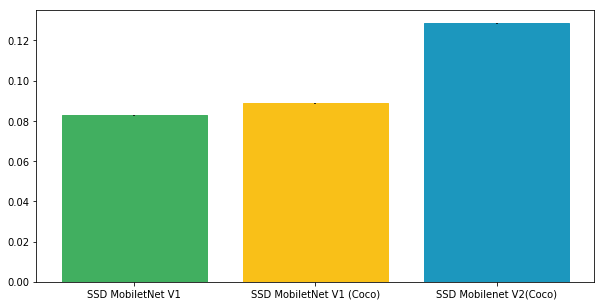

In [36]:
import os
import numpy as np
import glob
import scipy.stats as st
import math
import matplotlib.pyplot as plt

def conf_inter(sample, interval):
    avg = np.average(sample)
    std = st.sem(sample)
    conf = st.norm.interval(interval, loc=np.average(sample), scale=st.sem(sample)/math.sqrt(len(sample)))
    return conf


def collect_metrics(models):
    files = glob.glob('*.dat')
    files.sort()
    metrics = np.zeros(shape=(len(models), 4))

    for i, file in enumerate(files):
        with open(file,'r') as f:
            data = f.read()
            measurements = np.array(data.split('\n'))
            measurements = measurements[measurements != ''].astype(np.float32)
            avg = np.average(measurements)
            std = st.sem(measurements)
            conf = conf_inter(measurements, 0.95)
            metrics[i,:] = [avg, std, conf[0], conf[1]]
    return metrics


def plot_time_bars(models, averages, errors, colors=None):
    fig, axis = plt.subplots(1, 1, figsize=(10, 5))
    bars = axis.bar(models, averages, yerr=errors)
    if(colors == None):
        for bar in bars:
            color = np.random.rand(3)
            print(color)
            bar.set_color(color)
    else:
        for bar, color in zip(bars, colors):
            bar.set_color(color)

    if(os.path.exists('charts/bar.jpg')):
        os.remove('charts/bar.jpg')
    plt.savefig('charts/bar.jpg')

models = ['SSD MobiletNet V1', 'SSD MobiletNet V1 (Coco)', 'SSD Mobilenet V2(Coco)']
metrics = collect_metrics(models)
averages = metrics[:,0]
stds = metrics[:, 1]
errors = averages-metrics[:,2]
plot_time_bars(models, averages, errors)


<h2>Introdução</h2>
<p>Este trabalho tem o propósito de realizar a comparação quantitativa de modelos de aprendizado de máquina voltados à detecção de objetos em imagens. Houve interesse, sobretudo, em estudar a aplicabilidade destes modelos em circunstâncias que  imponham limitações ao hardware utilizado, como em computadores pessoais de baixo custo.</p>
<p>Com tal finalidade, foram selecionados modelos baseados em técnicas Deep Learning, 
    
    
    
    
    realizados testes que permitem a extração de métricas de desempenho</p>

In [ ]:
<h2>Metodologia</h2>
<p>Os testes foram </p>